**Import modules and set paths.**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import glob
# from multiprocess import Pool
from copy import deepcopy
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd 
# from scipy.linalg import lstsq
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from ipywidgets import interact

from lininvbox.lininvbox.equation import Term
from lininvbox.lininvbox.constructors import *
from lininvbox.lininvbox.operations import *
from lininvbox.lininvbox.inversion import Inversion
from lininvbox.lininvbox.constraints import *
from lininvbox.lininvbox.regularisation import *
from lininvbox.lininvbox.utils import delete_directory
from magscales.magscales import Richter1958
from plotconf import matsettings


using numpy v1.21.0.
using pandas v1.3.0.


## Yellowstone National Park $M_L$ Non-Paramatric Inversion Bootstrapping
### A notebook to perform bootstrapping for a given YP $M_L$ model to estimate the model uncertainty.



#### Load the model and catalog.

In [2]:
def vis_inv_output(inv):

    terms = inv.m.term_map.values.keys()
    X, Y = [],[]
    for term in terms:
        tmp = inv.m.term_map.get_term(term)
        if term == "MLi":
            X.append(tmp['unique_indices'])
        else:
            X.append(tmp['unique_labels'])
        Y.append(tmp['model_values'])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, y, x, term, x_lab in zip(axes, Y, X, terms, ["Rhyp [km]", "Ev #", "Sj"]):
        ax.plot(x, y, 'ks', mfc='none')
        ax.set_ylabel(term)
        ax.set_xlabel(x_lab)
        if term == "Sj":
            ax.tick_params(axis='x', labelrotation = 90)
            
    return fig, axes

class FileManager():
    
    @property
    def cat(self) -> pd.DataFrame:
        return self._cat
    @cat.setter
    def cat(self, cat: pd.DataFrame):
        assert type(cat) is pd.DataFrame
        self._cat = cat
        
    @property
    def model(self)->pd.DataFrame:
        return self._model
    @model.setter
    def model(self, mod: pd.DataFrame):
        assert type(mod) is pd.DataFrame
        self._model = mod

session = FileManager()
@interact
def load_data(path=sorted(glob.glob("../catalogs/amplitudes/*geobalanced.csv"))):
    tdf = pd.read_csv(path)
    print(f"loaded catalog {path.split('/')[-1]} ...")  
    session.cat = tdf.copy()
    session.cat_path = path
    return session.cat.head()

@interact
def load_model(path=sorted(glob.glob("../mlinversion/.model/*.json"))):
    tdf = pd.read_json(path)
    print(f"loaded model {path.split('/')[-1]} ...") 
    session.model = tdf.copy()
    session.model_path = path
    return session.model

interactive(children=(Dropdown(description='path', options=('../catalogs/amplitudes/yellowstone.amps.clean.geo…

interactive(children=(Dropdown(description='path', options=('../mlinversion/.model/YPML-model-MLi-4-Sj-1.json'…

In [3]:
def model_df_to_terms(mod_df):
    
    terms = []
    for i, row in mod_df.T.iterrows():
        
        name = i
        rl = np.array(row["raw_labels"])
        sign = row['sign'][0]
        kind = row["kind"].upper()
        
        if kind == "LINEAR INTERPOLATION":
            
            ul = np.array(row["unique_labels"])
            terms.append(Term(name, kind, rl, unique_labels=ul, sign=sign))
            continue
        
        terms.append(Term(name, kind, rl, sign=sign))    

    return terms

def model_df_to_constraints(mod_df):
    
    cons = OrderedDict()
    for i, row in mod_df.T.iterrows():
        name = i
        if row['constraints']:
            cons[name] = row['constraints']
    
    return cons


mcat = session.model.copy(deep=True)  

logA0np, MLip, Sjp = model_df_to_terms(mcat)

G = LinInterpCoeffs(logA0np) + ConstantCoeffs(MLip) + ConstantCoeffs(Sjp)
d = DataArray(session.cat['halfAmpH'].apply(np.log10))
Gamma = Regularisation(G.term_map, 
                       regs=OrderedDict(
                               logA0n=dict(
                                   kind=mcat.T.loc["logA0n"]['regularisation']['kind'],
                                   alpha=mcat.T.loc["logA0n"]['regularisation']['alpha']
                                          )
                                        )
                        )
C = Constraints(G.term_map, constraints=model_df_to_constraints(mcat))

### Do inversion and validate it.

In [4]:
pct=0.2
inv = Inversion("YPML-BTS")
# x = np.random.choice(G.matrix.shape[0], int(np.ceil(np.round(G.matrix.shape[0]*pct)/2)*2), replace=False)
# np.random.shuffle(x)
# keep, replace = x[:int(np.round(len(x)/2, 0))], x[int(np.round(len(x)/2, 0)):]

# G.matrix.data[replace] = G.matrix.data[keep]
# G.matrix.col[replace] = G.matrix.col[keep]
# G.matrix.row[replace] = G.matrix.row[keep]

# d.array.data[replace] = d.array.data[keep]
# d.array.col[replace] = d.array.col[keep]
# d.array.row[replace] = d.array.row[keep]
    
m = inv.invert(G, d, constraints=C, regularisation=Gamma)

#### Ensure that the model was loaded and recreated correctly.
If we perfrom the inversion from scratch using the same data, then we should expect the result to be perfectly correlated with the one we loaded.
We just want to make this check before bootstrapping to ensure our bootstrap inversions belong to the set of results related to the original! 

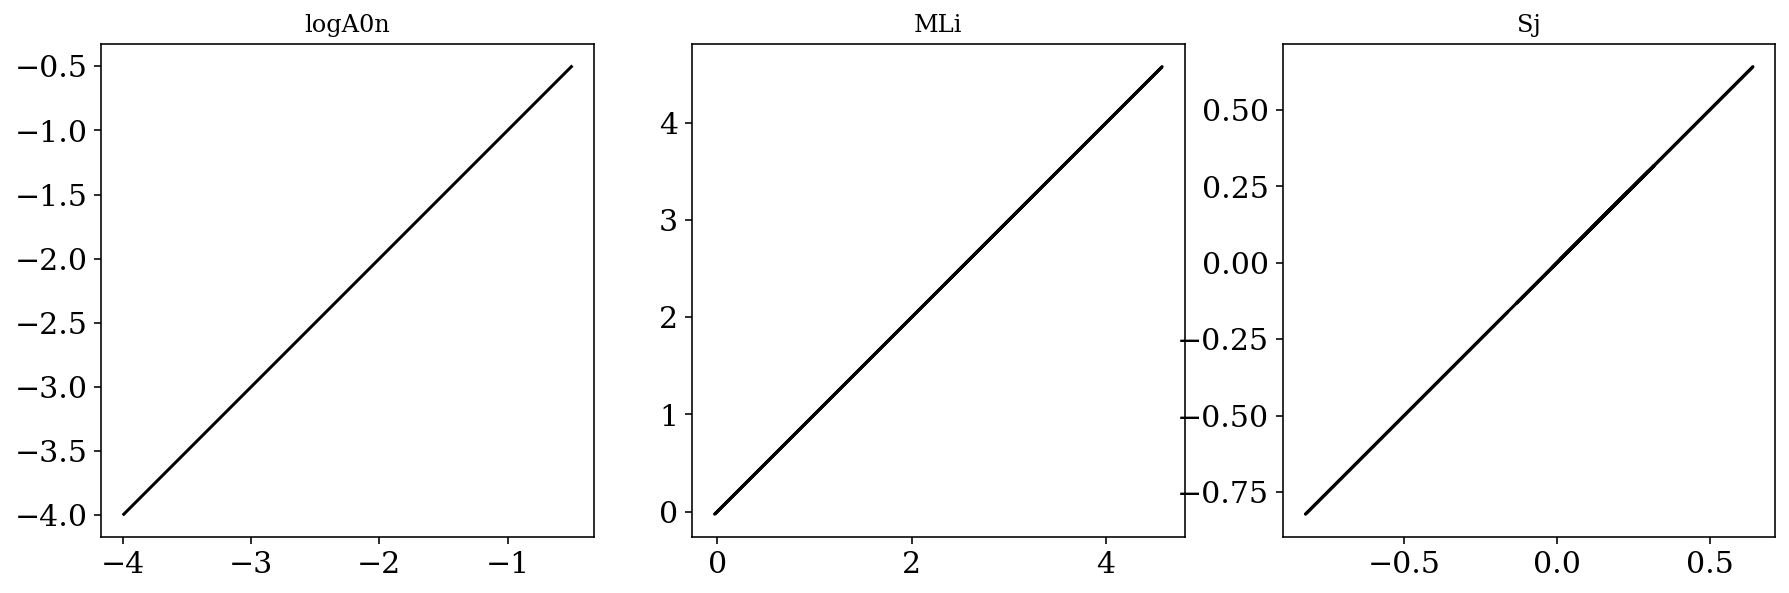

In [5]:
test = pd.DataFrame(G.term_map.values)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for orig, loaded, ax in zip(mcat.T.iterrows(), test.T.iterrows(), axes.flatten()):

    on, rown = orig
    ol, rowl = loaded
    ax.set_title(f"{on}")
    ax.plot(rown["model_values"], rowl["model_values"], 'k')
    ax.set_aspect('equal')

In [6]:
def do_bts_serial(pct, _G, _d, _C, _Gamma):
    
    inv = Inversion("")
#     print(_G)
    
    x = np.random.choice(_G.matrix.shape[0], int(np.ceil(np.round(_G.matrix.shape[0]*pct)/2)*2), replace=False)
    np.random.shuffle(x)
    keep, replace = x[:int(np.round(len(x)/2, 0))], x[int(np.round(len(x)/2, 0)):]
    
    _G = deepcopy(G)
    _d = deepcopy(d)
    
    tG = G.matrix.toarray()
    td = d.array.toarray()
    
    tG[replace] = tG[keep]
    td[replace] = td[keep]

    _G.matrix = coo_matrix(tG)
    _d.matrix = coo_matrix(td)
    
    m = inv.invert(_G, _d, constraints=_C, regularisation=_Gamma, inplace=False)

    return m.array.toarray()[:_G.matrix.shape[1]]

def run_bts(N, pct, G, d, constraints, regularisation):
#     global pct, G, d, constraints, regularisation
    bts_out = []
    for _ in range(N):
        bts.append(do_bts_serial(pct, G, d, constraints, regularisation))

    bts_out = np.concatenate(bts_out, axis=1)
    
    return bts_out 

### Run the bootstrapping

In [7]:
how = "SERIAL" # "PARALLEL"
poolsize = 7
NBTS = 1000
pct = 0.2
overwrite = False
fname = session.model_path.split("/")[-1].split(".")[0]

def run_bootstrap_session(NBTS,
                          G, 
                          d, 
                          pct,
                          how="SERIAL",  
                          fname = fname,
                          overwrite = False, 
                          constraints = None, 
                          regularisation = None,
                          root = "../mlinversion/.bts"
                         ):

    if not overwrite:
        try:
            return np.load(f"{root}/{fname}.npy")
        except FileNotFoundError:
            pass
            
    #TODO: Fix parallel implementation - low priority.
#     if how.upper() == "PARALLEL":
#         with Pool(poolsize) as p:
#             print(f"Running {NBTS} bootstrap iterations in parrallel using {poolsize} processes.")
#             bts = np.concatenate(p.map(run_bts, [10 for _ in range(int(NBTS/10))]), axis=1)
    if how.upper() == "SERIAL":
        print(f"Running {NBTS} bootstrap iterations in serial.")
        bts = run_bts(NBTS, pct, G, d, constraints, regularisation)
    
    os.makedirs(f"{root}/", exist_ok=True)
    np.save(f"{root}/{fname}.npy", bts)
    
    return bts

bts = run_bootstrap_session(
    NBTS, 
    G, 
    d, 
    pct, 
    fname = fname, 
    constraints = C, 
    regularisation = Gamma, 
    overwrite = overwrite
    )

In [10]:
#bootstrap statistics
mn = bts.mean(axis=1)
mdn = np.median(bts, axis=1)
std = bts.std(axis=1)
nfc = std*2
var = np.var(bts, axis=1)
vars = np.max(bts, axis=1) - mn
e_map = dict(mean = mn, median=mdn, std=std, nfc=nfc, var=var)
# the distance correction values presented by Luckett et al. (2019)
dc_params = {
    "UK": (1.11, 0.00185, -2.09, -1.16, 0.2),
    "Amatrice": (1.11, 0.00185, -2.09, -3.05, 0.17),
    "Northern_Norway": (0.91, 0.00087, -1.67, -0.74, 0.09)
}

def parametric_distance_corr(r, a, b, c, d, e):
    """
    Computes the distance correction of a parametric model with 5 parameters.
    """
    return a * np.log10(r) + b * r + d * np.exp(-e * r) + c + 3 


def log_bilinear(x, bp, a):
    """
    Computes predicted values for a given bilinear model in logspace i.e., log(x) and log(y).

    Parameters
    ----------
    x: np.ndarray
        The x values of the model - not in log units.
    bp: float
        The breakpoint between linear segments.
    a: tuple(float, float)
        A tuple containing the slopes of each linear segment (before and after the breakpoint).

    Returns
    -------
    y: np.ndarray
        The array of predicted values for the bilinear model. 
    """
    y = np.zeros(x.size)

    y[x <= bp] = a[0] * np.log10(x[x <= bp])

    y[x > bp] = a[0] * np.log10(bp) + a[1] * np.log10(x[x > bp] / bp)

    return y

def vis_bts_inv_output(inv, e_map, err, cap = 60):
        
        
    terms = inv.m.term_map.values.keys()
    X, Y, Z = [],[],[]
    for term in terms:
        tmp = inv.m.term_map.get_term(term)
        if term == "MLi":
            X.append(tmp['unique_indices'])
        else:
            X.append(tmp['unique_labels'])
        Y.append(tmp['model_values'])
        Z.append(tmp['model_indices'])

    fig, axes = plt.subplots(2, 2, figsize=(11, 10))
    axes = axes.flatten()
    for x, y, z, term, x_lab, y_lab, sym, ms, pos in zip(X, Y, Z, terms,
                                                        [r"$R$ $\mathrm{[km]}$", "Event #", "Station"], 
                                                        [r"$-\mathrm{log(A_0)}_n$", r"$M_{L_{i}}$", r"$S_j$"],
                                                        ['ks', 'k.', 'r^'],
                                                        [6, 7, 10],
                                                        [0, 2, 3]
                                                        ):
        y = -y if term == "logA0n" else y
        axes[pos].plot(x, y, sym, mfc='none', ms=ms, zorder=10, label="YP21")
        axes[pos].set_ylabel(y_lab)
        axes[pos].set_xlabel(x_lab)
        
        if term == "logA0n":

            axes[1].plot(x[x<=cap], y[x<=cap], sym, mfc='none', label='YP21')
            axes[pos].invert_yaxis()
            axes[1].invert_yaxis()
            r = Richter1958()
            axes[pos].plot(
                r.distances[r.distances<=180], 
                -r.logA0[r.distances<=180], 
                '^',
                color = 'k', 
                zorder = 1, 
                label = "R58",
                )

            axes[pos].fill_between(x, y + e_map[err][z], y - e_map[err][z], color='grey', alpha=0.5)
            # TODO: Make this comparison plot a separate function
            # plot the - rather compilicated - comparison of near-source 
            d = np.geomspace(3, cap, 30)
            dd = np.arange(0, cap + 1)
            bp = 15
            a = 1, 3
            geo = log_bilinear(dd, bp, a)
            axes[1].semilogx(dd[dd<=bp], geo[dd<=bp], ':', lw=3, color='grey', label=r'${R_{hyp}}^{-1}$')
            axes[1].plot(dd[dd>=bp], geo[dd>=bp], '--', lw=3, color='grey', label=r'${R_{hyp}}^{-3}$')
            _ = axes[1].set(xlabel=r"$R_{hyp}$ $\mathrm{[km]}$", ylim=[3, 0], xlim=[1, 100])
            axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

            
            for region, mk, leg_lab in zip(["UK", "Amatrice", "Northern_Norway"], ['-*', '-^', '-s'], ["UK", "Am", "NN"]):
                axes[1].plot(
                    d[::3], 
                    parametric_distance_corr(d[::3], *dc_params[region]), 
                    mk, 
                    lw=0.5,
                    mfc='none',
                    color='k',
                    label=f"L19-{leg_lab}"
                    )

            # axes[-1].plot(
            #     r.distances[r.distances<=cap], 
            #     r.logA0[r.distances<=cap], 
            #     'k^', 
            #     zorder = 1, 
            #     label = "R58"
            #     )
        
        if term == "MLi":
            fx = np.array(list(inv.m.term_map.get_term("MLi")['constraints'].items()))
            fy = inv.m.term_map.get_term("MLi")['unique_labels']
            fY = inv.m.term_map.get_term("MLi")['model_values']
            fX = inv.m.term_map.get_term("MLi")['unique_indices']
            fx, fy = fX[np.isin(fy, fx)], fY[np.isin(fy, fx)] 
            axes[pos].plot(fx, fy, 'rs', mfc='none')
            
        if term == "Sj":
            axes[pos].errorbar(x, y, e_map[err][z], ecolor='k', capsize=4, elinewidth=2, linestyle='', zorder=0)
            axes[pos].tick_params(axis='x', labelrotation = 90)
            s = f"\u03A3 {r'$S_j$'}={np.sum(G.term_map.get_term('Sj')['model_values']):.0E}"
            axes[pos].text(0.01, 0.95, s, horizontalalignment='left', verticalalignment='center', transform=axes[pos].transAxes)
            axes[pos].hlines(0, 0, len(x)-1, color='k', linestyles='dashed')
            sj = np.array(list(inv.m.term_map.get_term("Sj")['constraints'].items())[1:])
            if sj.size > 1:
                axes[pos].plot(sj[:,0], sj[:,1].astype(float), 's', color='r', ms=10)
            axes[pos].set_ylim([-1, 1])
            axes[pos].xaxis.set_ticklabels([code.split(".")[-1] for code in x])
            
        
    tick_spacings = [30, 250]
    for i, ax in enumerate([axes[0], axes[2]]):
        tick_spacing = tick_spacings[i]
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    fig.tight_layout()
    return fig, axes

@interact
def interact_vis(err=['std', 'nfc', 'var'], cap=[100,]):
    global inv, e_map
    plt.close()
    fig, _ = vis_bts_inv_output(inv, e_map, err, cap)
    fname = session.model_path.split("/")[-1].split(".")[0]
    fig.savefig(f"../figures/INVOUT-{err}-{fname}.pdf");
    plt.show();

interactive(children=(Dropdown(description='err', options=('std', 'nfc', 'var'), value='std'), Dropdown(descri…

/var/folders/rp/8sbsdrv12vxcv2m5tfwp4rf00000gn/T/ipykernel_61043/2993776636.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  diff.append(float(np.abs(YP-R)) if YP-R else np.nan)


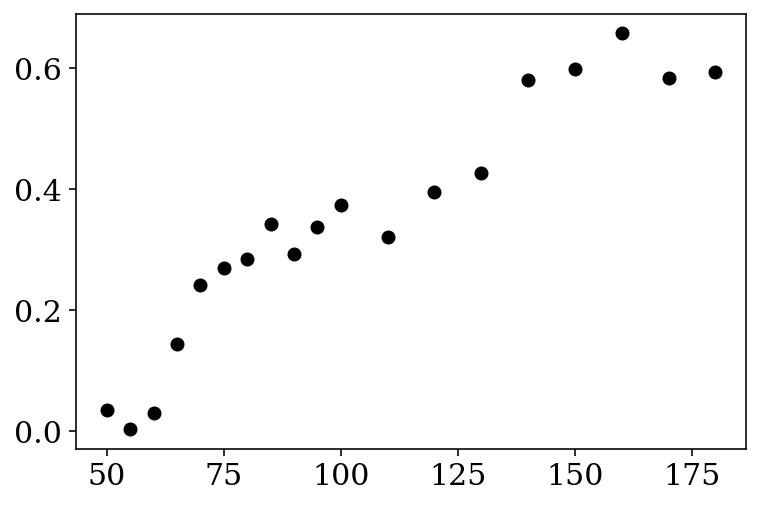

In [9]:
# stuff

r = Richter1958()
Ds = [] 
diff = []
for D in np.arange(50, 185, 5):
    loc = np.where(np.array(session.model.loc["unique_labels", "logA0n"])==D)
    YP = np.array(session.model.loc["model_values", "logA0n"])[loc]
    R = r.logA0[r.distances==D]
    Ds.append(D)
    diff.append(float(np.abs(YP-R)) if YP-R else np.nan)
    
plt.plot(Ds, diff, 'ko')